In [6]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
from scipy.optimize import curve_fit

from astropy.nddata import CCDData
from astropy.io import fits
from astropy.time import Time
from astropy.table import hstack, vstack
from astropy import units as u
from astropy.stats import sigma_clip

import ysfitsutilpy as yfu
import ysphotutilpy as ypu
import ysvisutilpy as yvu

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import gridspec


def linf(x, a, b):
    return a*x + b

def mkreg(stars, ephem, rap_arcsec, output, 
          c_star='green', c_target='red', width=2, font="helvetica 10 normal roman"):
    globstr = 'global color=green dashlist=8 3 width=2 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n'
    apstr = 'circle({},{},{}") # width={:.0f}, color={:s}, text={{{:s}}}\n'
    anstr = 'annulus({},{},{}",{}") # width={:.0f}, color={:s}, text={{{:s}}}\n'
    with open(output, 'w+') as ff:
        ff.write("# Region file format: DS9 version 4.1\n")
        ff.write(globstr.format(c_star))
        ff.write('fk5\n')
        
        ff.write(apstr.format(
            ephem["RA"],
            ephem["DEC"],
            rap_arcsec,
            width,
            c_target,
            "Target"
        ))
        for i, row in enumerate(stars):
            ff.write(apstr.format(
                row["RAJ2000"], 
                row["DEJ2000"], 
                rap_arcsec, 
                width, 
                c_star,
                f"#{i + 1:02.0f} (R = {row['Rmag']:.2f})"
            ))
            
            
def plotting(ax_l, ax_r, ax_c, phot_stars, phot_targ, m_min=13.5, m_max=16.1):
    errbfmt = dict(marker='x', ls='', capsize=5, elinewidth=0.5)

    for ax in [ax_l, ax_r, ax_c]:
        ax.cla()
    try:
        ax_c2.cla()
    except UnboundLocalError:
        pass

    m_true = phot_stars["Rmag"]
    m_inst = phot_stars["mag"]
    e_m_true = phot_stars["e_Rmag"]
    e_m_inst = phot_stars["merr"]
    color = phot_stars["grcolor"]
    e_color = phot_stars["e_grcolor"]
    Z = m_true - m_inst
    e_Z = np.sqrt(e_m_true**2 + e_m_inst**2)
    s_Z = np.std(Z, ddof=1)  # standard deviation
    m_Z = np.mean(Z)         # Simple mean
    Z_fit = np.average(Z, weights=(1/e_Z**2))
    e_Z_fit = np.sqrt(1 / np.sum(1/e_Z**2))

    mm = np.linspace(m_min, m_max, 2)  # grid
    cc = np.linspace(color.min(), color.max(), 2)  # grid
    p_ll, _ = curve_fit(linf, m_true, m_inst, sigma=e_m_inst, absolute_sigma=True)
    p_cz, _ = curve_fit(linf, color, Z, sigma=e_Z, absolute_sigma=True)

    ax_l.errorbar(m_true, m_inst, xerr=e_m_true, yerr=e_m_inst, **errbfmt)
    ax_l.plot(mm, linf(mm, *p_ll), 'k-', label=f"y={p_ll[0]:.4f}x + {-p_ll[1]:.3f}")
    ax_l.plot(mm, mm - Z_fit, 'r-', label=f"y=x + {Z_fit:.3f} (see right)")
    ax_l.axhline(phot_targ['mag'], color='g', label="target")
    ax_l.set(
        ylabel="R$_\mathrm{inst}$", 
        title="Linearity Curve"
    )
    ax_l.legend(loc=2, framealpha=0, fontsize=10)
    for j, (x_i, y_i) in enumerate(zip(m_true, m_inst)):
        ax_l.text(x=x_i, y=y_i, s=j+1)

    ax_r.errorbar(m_true, Z, yerr=e_Z, **errbfmt)
    ax_r.axhline(Z_fit, color='r', ls='-', lw=1)
    ax_r.axhline(Z_fit + e_Z_fit, color='r', ls='--', lw=1, label=None) 
    ax_r.axhline(Z_fit - e_Z_fit, color='r', ls='--', lw=1, label=None)
    ax_r.axhline(m_Z + s_Z, color='b', ls=':', lw=1, label=None) 
    ax_r.axhline(m_Z - s_Z, color='b', ls=':', lw=1, label=None)
    ax_r.set(xlabel="R from PS1 g/r (Tonry+ 2012)",
             ylabel="R - R$_\mathrm{inst}$",
             xlim=(m_min, m_max),
             ylim=(Z_fit - 1, Z_fit + 1)
            )
    for j, (x_i, y_i) in enumerate(zip(m_true, Z)):
        ax_r.text(x=x_i, y=y_i, s=j+1)

    ax_c.errorbar(color, Z, yerr=e_Z, xerr=e_color, **errbfmt)
    ax_c.axhline(Z_fit, color='r', ls='-', lw=1, label=f"wieghted avg = {Z_fit:.3f}")
    ax_c.axhline(Z_fit + e_Z_fit, color='r', ls='--', lw=1, label=f"err = {e_Z_fit:.3f}") 
    ax_c.axhline(Z_fit - e_Z_fit, color='r', ls='--', lw=1, label=None)
    ax_c.axhline(m_Z, color='b', ls='-', lw=1, label=f"simple avg = {m_Z:.3f}")
    ax_c.axhline(m_Z + s_Z, color='b', ls=':', lw=1, label=f"std = {s_Z:.3f}") 
    ax_c.axhline(m_Z - s_Z, color='b', ls=':', lw=1, label=None)
    ax_c.plot(cc, linf(cc, *p_cz), 'k-')
    ax_c.legend(loc=2, framealpha=0, ncol=2)
    ax_c.set(xlabel="g - r from PS1",
             title="Z = R - R$_\mathrm{inst}$ = (k + k''X)C + (zero + k'X)")

    ax_c2 = ax_c.twinx()
    ax_c2.plot(np.nan, np.nan, 'k-',
               label=f"y={p_cz[0]:.3f}x + {p_cz[1]:.3f}")
    ax_c2.legend(loc=4)
    ax_c2.axis('off')

    for j, (x_i, y_i) in enumerate(zip(color, Z)):
        ax_c.text(x=x_i, y=y_i, s=j+1)

    yvu.linticker(
        [ax_l, ax_r, ax_c],
        xmajlockws=[0.5, 0.5, 0.2],
        xminlockws=[0.1, 0.1, 0.1],
        ymajlockws=[0.5, 0.5, 0.1],
        yminlockws=[0.1, 0.1, 0.05]
    )

    plt.tight_layout()
    
    result = dict(
        linSlope=p_ll[0],
        linInter=p_ll[1], 
        colorSlope=p_cz[0],
        colorInter=p_cz[1],
        Zpt=Z_fit,
        e_Zpt=e_Z_fit,
        Zavg=m_Z,
        Zstd=s_Z
    )
    return result
        
USEFUL_KEYS = ["DATE-OBS", "FILTER", "OBJECT", "EXPTIME", "IMAGETYP",
               "AIRMASS", "XBINNING", "YBINNING", "CCD-TEMP", "SET-TEMP",
               "OBJCTRA", "OBJCTDEC", "OBJCTALT"]

TOPPATH = Path("/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original")  # the directory you saved the FITS files
REDDIR = TOPPATH/"reduced"
REDDIR.mkdir(parents=True, exist_ok=True)
allfits = list(REDDIR.glob("*.fits"))

gain_original = 1.36
rdnoise_original = 9.0 
bin_area = 4*4
gain = gain_original*bin_area
rdnoise = rdnoise_original * np.sqrt(bin_area)

In [7]:
#problem 1
summary = yfu.make_summary(allfits, keywords = USEFUL_KEYS, sort_by = 'DATE-OBS')

Extracting keys:  ['DATE-OBS', 'FILTER', 'OBJECT', 'EXPTIME', 'IMAGETYP', 'AIRMASS', 'XBINNING', 'YBINNING', 'CCD-TEMP', 'SET-TEMP', 'OBJCTRA', 'OBJCTDEC', 'OBJCTALT']


In [8]:
#problem 2
midtimes = Time(summary['DATE-OBS'], format = 'isot') + summary['EXPTIME'] * u.s/2

In [9]:
#problem 3
snuo = dict(lon=126.954, lat=37.455, elevation=150)

q = ypu.HorizonsDiscreteEpochsQuery(
    targetname="155140",
    location=snuo,
    epochs=midtimes.jd
)
q.query()
eph = q.query_table

Query: 155140 at {'lon': 126.954, 'lat': 37.455, 'elevation': 150} for 104 epochs
Query chopped into 2 chunks: Doing  1... 

/home/ehko/anaconda3/lib/python3.7/site-packages/astroquery/jplhorizons/core.py:604: UserWarning: The uri used in this query is very long and might have been truncated. The results of the query might be compromised. If you queried a list of epochs, consider querying a range.
  warnings.warn(('The uri used in this query is very long '


2... Query done.


In [10]:
#problem 4
summary = hstack([summary, eph])
summary.to_pandas().to_csv(TOPPATH/"20191012_2005UD.csv")

/home/ehko/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'surfbright' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ehko/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'illum_defect' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ehko/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'ang_width' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ehko/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'PDObsLon' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ehko/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'PDObsLat' from integer

In [11]:
# problem 5 : I confirmed
# problem 6: I confirmed

In [12]:
#problem 7
fwhm = 3                  # Check this from, e.g., ginga, a priori.
fwhm_arcsec = fwhm * 1.2  # 1.2 arcsec/pixel

row = summary[5]
fpath = Path(row['file'])
print(fpath)
ccd = yfu.load_ccd(fpath)
err = yfu.make_errmap(ccd)
hdr = ccd.header

# Query sidereal objects (PS1)
cent_coord = yfu.center_radec(header=hdr, center_of_image=True)
rad = yfu.fov_radius(header=hdr, unit=u.deg)

# Initialize PanSTARRS1 class
ps1 = ypu.PanSTARRS1(
    ra=cent_coord.ra.value, 
    dec=cent_coord.dec.value, 
    radius=rad,
    column_filters={'rmag':'10.0..16.0', 'e_rmag':'<0.10'}
)
isnear = ypu.organize_ps1_and_isnear(
    ps1=ps1,
    header=hdr,
    bezel=50,
    group_crit_separation=6*fwhm,
    select_filter_kw=dict(filter_names=['g', 'r'], n_mins=5),
    drop_by_Kron=True,
    calc_JC=True  # This uses g-r color, so both g and r must not be removed.
)
stars = ps1.queried

print(isnear)

/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-112427_R_60.0.fits


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 23 objects remaining:   3 masked out of  26 based on [50 50]-pixel bezel.
 21 objects remaining:   2 masked out of  23 based on DAOGROUP with 18.000-pixel critical separation..
 19 objects remaining:   2 masked out of  21 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 17 objects remaining:   2 masked out of  19 based on the Kron magnitude criterion.
 13 objects remaining:   4 masked out of  17 based on o_['g', 'r']mag >= [5 5].
False


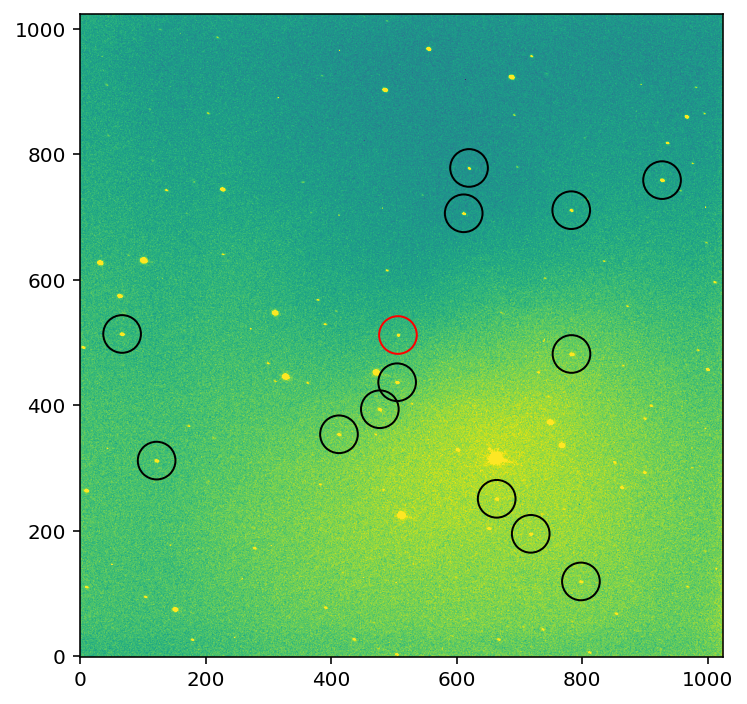

In [13]:
#problem 8
targ_xy = ypu.get_xy(hdr, row["RA"], row["DEC"])
ap_targ, _ = ypu.circ_ap_an(targ_xy, fwhm=fwhm, f_ap=10)
ap_stars, _ = ypu.circ_ap_an([stars["x"], stars["y"]], fwhm=fwhm, f_ap=10)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), 
                        sharex=False, sharey=False, gridspec_kw=None)
yvu.norm_imshow(axs, ccd, zscale=True)
ap_stars.plot(axs)
ap_targ.plot(axs, color='r')
plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)
plt.show()

In [19]:
#problem 9
regpath = fpath.parent/f"{fpath.stem}.reg"
mkreg(stars, row, 2.*fwhm_arcsec, regpath)

In [20]:
#Aperture photometry
#problem 1
ap_stars, an_stars = ypu.circ_ap_an([stars["x"], stars["y"]], fwhm=fwhm, f_ap=2, f_in=4, f_out=6)
ap_targ, an_targ = ypu.circ_ap_an(targ_xy, fwhm=fwhm, f_ap=2, f_in=4, f_out=6)

phot_targ = ypu.apphot_annulus(ccd=ccd, aperture=ap_targ, annulus=an_targ, error=err)

phot_stars = ypu.apphot_annulus(ccd=ccd, aperture=ap_stars, annulus=an_stars, error=err)
phot_stars = hstack([phot_stars, stars]).to_pandas()
phot_stars.to_csv(fpath.parent/f"{fpath.stem}_stars.csv", index=False)
# use phot_stars and phot_targ to display the tables. 

In [21]:
#problem 2
#The factors multiplied to ``fwhm`` to set the inner sky radius

{'linSlope': 0.8735059796734942,
 'linInter': -16.58658272950679,
 'colorSlope': 0.2152739842601006,
 'colorInter': 18.310778823265892,
 'Zpt': 18.42158569071372,
 'e_Zpt': 0.0195700125224494,
 'Zavg': 18.423216512384805,
 'Zstd': 0.13383882077164913}

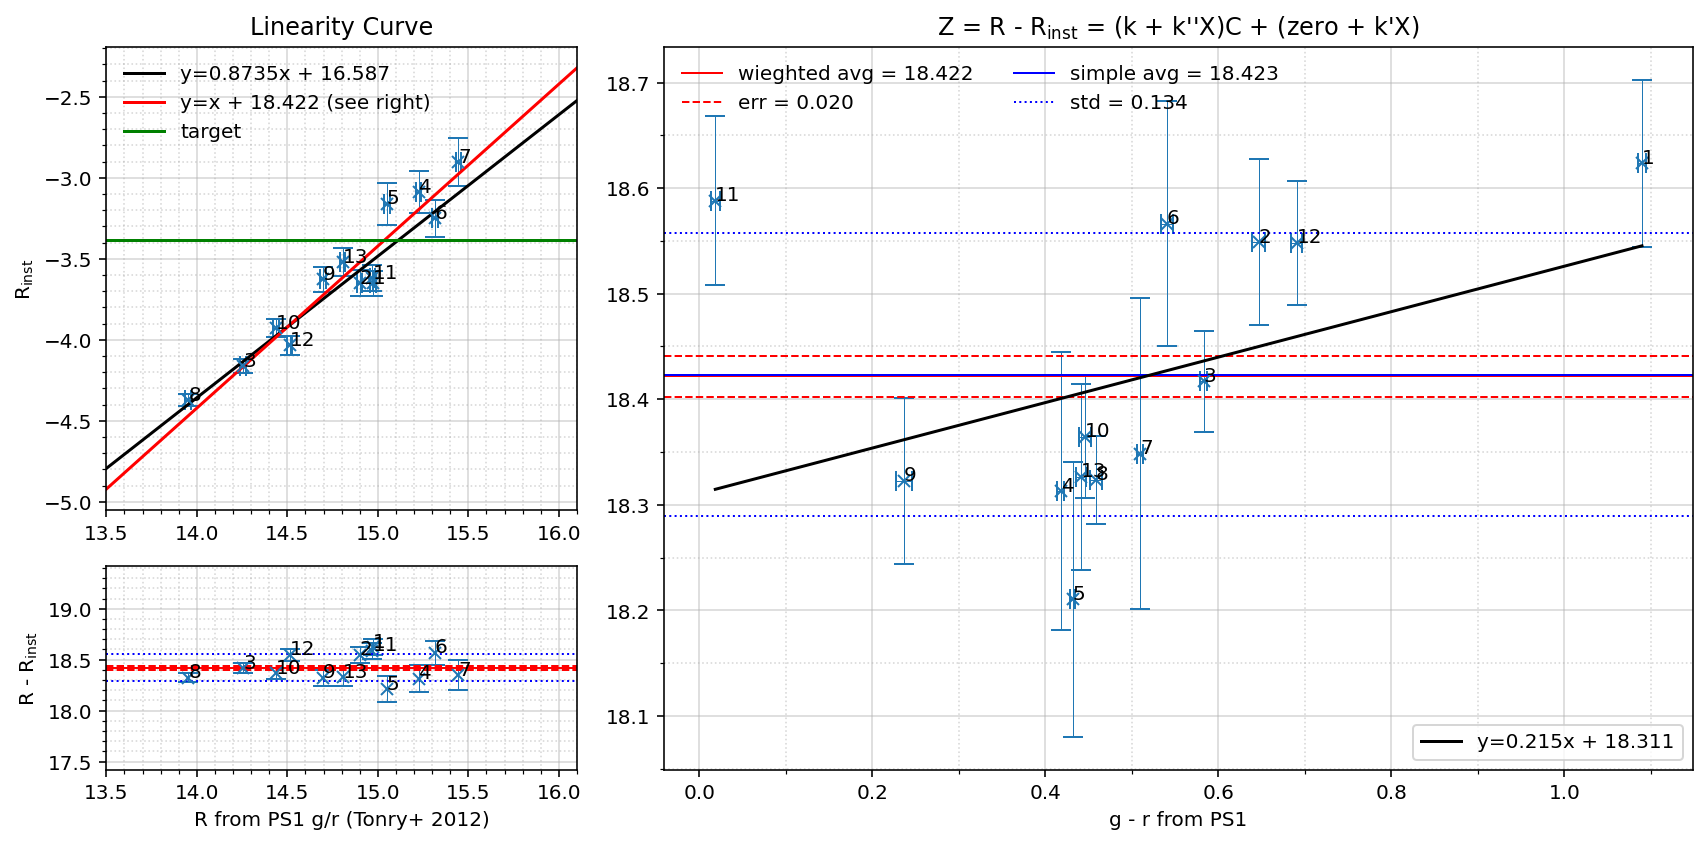

In [22]:
#problem 3
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 3)
# NOTE: Z = R - R_inst = zp + 1st ext
ax_l = fig.add_subplot(gs[:2, 0])                # Linearity plot
ax_r = fig.add_subplot(gs[2, 0], sharex=ax_l)    # residual plot
ax_c = fig.add_subplot(gs[:, 1:])                # C(g-r) VS Z plot

plotting(ax_l, ax_r, ax_c, phot_stars, phot_targ)

/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-105342_R_60.0.fits (RA, DEC) = (19.33921, +6.87353) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 26 objects remaining:   0 masked out of  26 based on [50 50]-pixel bezel.
 24 objects remaining:   2 masked out of  26 based on DAOGROUP with 18.000-pixel critical separation..
 21 objects remaining:   3 masked out of  24 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 19 objects remaining:   2 masked out of  21 based on the Kron magnitude criterion.
 13 objects remaining:   6 masked out of  19 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-110445_R_60.0.fits (RA, DEC) = (19.32284, +6.87245) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 23 objects remaining:   1 masked out of  24 based on [50 50]-pixel bezel.
 21 objects remaining:   2 masked out of  23 based on DAOGROUP with 18.000-pixel critical separation..
 19 objects remaining:   2 masked out of  21 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 17 objects remaining:   2 masked out of  19 based on the Kron magnitude criterion.
 12 objects remaining:   5 masked out of  17 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-110940_R_60.0.fits (RA, DEC) = (19.31555, +6.87197) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 22 objects remaining:   1 masked out of  23 based on [50 50]-pixel bezel.
 20 objects remaining:   2 masked out of  22 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   2 masked out of  20 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 16 objects remaining:   2 masked out of  18 based on the Kron magnitude criterion.
 12 objects remaining:   4 masked out of  16 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-111436_R_60.0.fits (RA, DEC) = (19.30824, +6.87148) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 21 objects remaining:   2 masked out of  23 based on [50 50]-pixel bezel.
 19 objects remaining:   2 masked out of  21 based on DAOGROUP with 18.000-pixel critical separation..
 17 objects remaining:   2 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 15 objects remaining:   2 masked out of  17 based on the Kron magnitude criterion.
 11 objects remaining:   4 masked out of  15 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-111932_R_60.0.fits (RA, DEC) = (19.30093, +6.87100) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 23 objects remaining:   3 masked out of  26 based on [50 50]-pixel bezel.
 21 objects remaining:   2 masked out of  23 based on DAOGROUP with 18.000-pixel critical separation..
 19 objects remaining:   2 masked out of  21 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 17 objects remaining:   2 masked out of  19 based on the Kron magnitude criterion.
 13 objects remaining:   4 masked out of  17 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-112427_R_60.0.fits (RA, DEC) = (19.29365, +6.87052) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 23 objects remaining:   3 masked out of  26 based on [50 50]-pixel bezel.
 21 objects remaining:   2 masked out of  23 based on DAOGROUP with 18.000-pixel critical separation..
 19 objects remaining:   2 masked out of  21 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 17 objects remaining:   2 masked out of  19 based on the Kron magnitude criterion.
 13 objects remaining:   4 masked out of  17 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-112923_R_60.0.fits (RA, DEC) = (19.28633, +6.87003) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 22 objects remaining:   4 masked out of  26 based on [50 50]-pixel bezel.
 20 objects remaining:   2 masked out of  22 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   2 masked out of  20 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 17 objects remaining:   1 masked out of  18 based on the Kron magnitude criterion.
 13 objects remaining:   4 masked out of  17 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-113418_R_60.0.fits (RA, DEC) = (19.27905, +6.86955) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 22 objects remaining:   4 masked out of  26 based on [50 50]-pixel bezel.
 20 objects remaining:   2 masked out of  22 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   2 masked out of  20 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 14 objects remaining:   4 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-113913_R_60.0.fits (RA, DEC) = (19.27176, +6.86906) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 22 objects remaining:   4 masked out of  26 based on [50 50]-pixel bezel.
 20 objects remaining:   2 masked out of  22 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   2 masked out of  20 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 14 objects remaining:   4 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-114408_R_60.0.fits (RA, DEC) = (19.26447, +6.86858) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 20 objects remaining:   4 masked out of  24 based on [50 50]-pixel bezel.
 18 objects remaining:   2 masked out of  20 based on DAOGROUP with 18.000-pixel critical separation..
 17 objects remaining:   1 masked out of  18 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 17 objects remaining:   0 masked out of  17 based on the Kron magnitude criterion.
 13 objects remaining:   4 masked out of  17 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-114904_R_60.0.fits (RA, DEC) = (19.25716, +6.86810) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 21 objects remaining:   2 masked out of  23 based on [50 50]-pixel bezel.
 19 objects remaining:   2 masked out of  21 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   1 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 14 objects remaining:   4 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-115400_R_60.0.fits (RA, DEC) = (19.24984, +6.86761) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 22 objects remaining:   2 masked out of  24 based on [50 50]-pixel bezel.
 20 objects remaining:   2 masked out of  22 based on DAOGROUP with 18.000-pixel critical separation..
 19 objects remaining:   1 masked out of  20 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 19 objects remaining:   0 masked out of  19 based on the Kron magnitude criterion.
 14 objects remaining:   5 masked out of  19 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-115856_R_60.0.fits (RA, DEC) = (19.24253, +6.86712) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 22 objects remaining:   2 masked out of  24 based on [50 50]-pixel bezel.
 20 objects remaining:   2 masked out of  22 based on DAOGROUP with 18.000-pixel critical separation..
 19 objects remaining:   1 masked out of  20 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 19 objects remaining:   0 masked out of  19 based on the Kron magnitude criterion.
 14 objects remaining:   5 masked out of  19 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-120351_R_60.0.fits (RA, DEC) = (19.23524, +6.86664) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 21 objects remaining:   2 masked out of  23 based on [50 50]-pixel bezel.
 19 objects remaining:   2 masked out of  21 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   1 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 14 objects remaining:   4 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-120847_R_60.0.fits (RA, DEC) = (19.22792, +6.86615) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 21 objects remaining:   2 masked out of  23 based on [50 50]-pixel bezel.
 19 objects remaining:   2 masked out of  21 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   1 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 14 objects remaining:   4 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-121343_R_60.0.fits (RA, DEC) = (19.22061, +6.86567) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 22 objects remaining:   1 masked out of  23 based on [50 50]-pixel bezel.
 20 objects remaining:   2 masked out of  22 based on DAOGROUP with 18.000-pixel critical separation..
 19 objects remaining:   1 masked out of  20 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 19 objects remaining:   0 masked out of  19 based on the Kron magnitude criterion.
 15 objects remaining:   4 masked out of  19 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-121838_R_60.0.fits (RA, DEC) = (19.21332, +6.86518) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 22 objects remaining:   1 masked out of  23 based on [50 50]-pixel bezel.
 20 objects remaining:   2 masked out of  22 based on DAOGROUP with 18.000-pixel critical separation..
 19 objects remaining:   1 masked out of  20 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 19 objects remaining:   0 masked out of  19 based on the Kron magnitude criterion.
 15 objects remaining:   4 masked out of  19 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-122333_R_60.0.fits (RA, DEC) = (19.20602, +6.86470) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 21 objects remaining:   1 masked out of  22 based on [50 50]-pixel bezel.
 19 objects remaining:   2 masked out of  21 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   1 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 14 objects remaining:   4 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-122829_R_60.0.fits (RA, DEC) = (19.19871, +6.86421) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 21 objects remaining:   0 masked out of  21 based on [50 50]-pixel bezel.
 19 objects remaining:   2 masked out of  21 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   1 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 14 objects remaining:   4 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-123324_R_60.0.fits (RA, DEC) = (19.19142, +6.86372) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 21 objects remaining:   2 masked out of  23 based on [50 50]-pixel bezel.
 19 objects remaining:   2 masked out of  21 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   1 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 15 objects remaining:   3 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-123819_R_60.0.fits (RA, DEC) = (19.18413, +6.86324) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 21 objects remaining:   2 masked out of  23 based on [50 50]-pixel bezel.
 19 objects remaining:   2 masked out of  21 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   1 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 15 objects remaining:   3 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-124315_R_60.0.fits (RA, DEC) = (19.17681, +6.86275) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 21 objects remaining:   1 masked out of  22 based on [50 50]-pixel bezel.
 19 objects remaining:   2 masked out of  21 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   1 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 15 objects remaining:   3 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-124810_R_60.0.fits (RA, DEC) = (19.16952, +6.86226) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 24 objects remaining:   3 masked out of  27 based on [50 50]-pixel bezel.
 19 objects remaining:   5 masked out of  24 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   1 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 15 objects remaining:   3 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-125306_R_60.0.fits (RA, DEC) = (19.16220, +6.86178) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 25 objects remaining:   2 masked out of  27 based on [50 50]-pixel bezel.
 20 objects remaining:   5 masked out of  25 based on DAOGROUP with 18.000-pixel critical separation..
 19 objects remaining:   1 masked out of  20 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 19 objects remaining:   0 masked out of  19 based on the Kron magnitude criterion.
 16 objects remaining:   3 masked out of  19 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-125802_R_60.0.fits (RA, DEC) = (19.15489, +6.86129) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 25 objects remaining:   2 masked out of  27 based on [50 50]-pixel bezel.
 20 objects remaining:   5 masked out of  25 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   2 masked out of  20 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 14 objects remaining:   4 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-130258_R_60.0.fits (RA, DEC) = (19.14757, +6.86080) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 24 objects remaining:   3 masked out of  27 based on [50 50]-pixel bezel.
 19 objects remaining:   5 masked out of  24 based on DAOGROUP with 18.000-pixel critical separation..
 17 objects remaining:   2 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 17 objects remaining:   0 masked out of  17 based on the Kron magnitude criterion.
 15 objects remaining:   2 masked out of  17 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-130753_R_60.0.fits (RA, DEC) = (19.14028, +6.86031) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 25 objects remaining:   2 masked out of  27 based on [50 50]-pixel bezel.
 20 objects remaining:   5 masked out of  25 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   2 masked out of  20 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 16 objects remaining:   2 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-131249_R_60.0.fits (RA, DEC) = (19.13297, +6.85982) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 24 objects remaining:   2 masked out of  26 based on [50 50]-pixel bezel.
 19 objects remaining:   5 masked out of  24 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   1 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   0 masked out of  18 based on the Kron magnitude criterion.
 16 objects remaining:   2 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-131745_R_60.0.fits (RA, DEC) = (19.12565, +6.85933) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 23 objects remaining:   3 masked out of  26 based on [50 50]-pixel bezel.
 18 objects remaining:   5 masked out of  23 based on DAOGROUP with 18.000-pixel critical separation..
 16 objects remaining:   2 masked out of  18 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 16 objects remaining:   0 masked out of  16 based on the Kron magnitude criterion.
 13 objects remaining:   3 masked out of  16 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-132240_R_60.0.fits (RA, DEC) = (19.11837, +6.85884) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 22 objects remaining:   5 masked out of  27 based on [50 50]-pixel bezel.
 17 objects remaining:   5 masked out of  22 based on DAOGROUP with 18.000-pixel critical separation..
 15 objects remaining:   2 masked out of  17 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 15 objects remaining:   0 masked out of  15 based on the Kron magnitude criterion.
 13 objects remaining:   2 masked out of  15 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-132736_R_60.0.fits (RA, DEC) = (19.11105, +6.85835) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 22 objects remaining:   4 masked out of  26 based on [50 50]-pixel bezel.
 15 objects remaining:   7 masked out of  22 based on DAOGROUP with 18.000-pixel critical separation..
 14 objects remaining:   1 masked out of  15 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 14 objects remaining:   0 masked out of  14 based on the Kron magnitude criterion.
 12 objects remaining:   2 masked out of  14 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-133232_R_60.0.fits (RA, DEC) = (19.10374, +6.85786) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 22 objects remaining:   2 masked out of  24 based on [50 50]-pixel bezel.
 15 objects remaining:   7 masked out of  22 based on DAOGROUP with 18.000-pixel critical separation..
 13 objects remaining:   2 masked out of  15 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 13 objects remaining:   0 masked out of  13 based on the Kron magnitude criterion.
 11 objects remaining:   2 masked out of  13 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-133727_R_60.0.fits (RA, DEC) = (19.09645, +6.85738) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 22 objects remaining:   1 masked out of  23 based on [50 50]-pixel bezel.
 15 objects remaining:   7 masked out of  22 based on DAOGROUP with 18.000-pixel critical separation..
 13 objects remaining:   2 masked out of  15 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 13 objects remaining:   0 masked out of  13 based on the Kron magnitude criterion.
 11 objects remaining:   2 masked out of  13 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-134223_R_60.0.fits (RA, DEC) = (19.08914, +6.85688) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 22 objects remaining:   1 masked out of  23 based on [50 50]-pixel bezel.
 15 objects remaining:   7 masked out of  22 based on DAOGROUP with 18.000-pixel critical separation..
 13 objects remaining:   2 masked out of  15 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 13 objects remaining:   0 masked out of  13 based on the Kron magnitude criterion.
 11 objects remaining:   2 masked out of  13 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-134719_R_60.0.fits (RA, DEC) = (19.08183, +6.85639) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 21 objects remaining:   3 masked out of  24 based on [50 50]-pixel bezel.
 14 objects remaining:   7 masked out of  21 based on DAOGROUP with 18.000-pixel critical separation..
 12 objects remaining:   2 masked out of  14 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 12 objects remaining:   0 masked out of  12 based on the Kron magnitude criterion.
 11 objects remaining:   1 masked out of  12 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-135216_R_60.0.fits (RA, DEC) = (19.07450, +6.85590) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 21 objects remaining:   3 masked out of  24 based on [50 50]-pixel bezel.
 14 objects remaining:   7 masked out of  21 based on DAOGROUP with 18.000-pixel critical separation..
 12 objects remaining:   2 masked out of  14 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 12 objects remaining:   0 masked out of  12 based on the Kron magnitude criterion.
 11 objects remaining:   1 masked out of  12 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-135712_R_60.0.fits (RA, DEC) = (19.06719, +6.85541) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 21 objects remaining:   3 masked out of  24 based on [50 50]-pixel bezel.
 14 objects remaining:   7 masked out of  21 based on DAOGROUP with 18.000-pixel critical separation..
 12 objects remaining:   2 masked out of  14 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 12 objects remaining:   0 masked out of  12 based on the Kron magnitude criterion.
 11 objects remaining:   1 masked out of  12 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-140207_R_60.0.fits (RA, DEC) = (19.05990, +6.85492) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 18 objects remaining:   5 masked out of  23 based on [50 50]-pixel bezel.
 13 objects remaining:   5 masked out of  18 based on DAOGROUP with 18.000-pixel critical separation..
 11 objects remaining:   2 masked out of  13 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 11 objects remaining:   0 masked out of  11 based on the Kron magnitude criterion.
 10 objects remaining:   1 masked out of  11 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-140703_R_60.0.fits (RA, DEC) = (19.05260, +6.85443) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 19 objects remaining:   4 masked out of  23 based on [50 50]-pixel bezel.
 14 objects remaining:   5 masked out of  19 based on DAOGROUP with 18.000-pixel critical separation..
 12 objects remaining:   2 masked out of  14 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 12 objects remaining:   0 masked out of  12 based on the Kron magnitude criterion.
 10 objects remaining:   2 masked out of  12 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-141159_R_60.0.fits (RA, DEC) = (19.04529, +6.85393) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 18 objects remaining:   4 masked out of  22 based on [50 50]-pixel bezel.
 13 objects remaining:   5 masked out of  18 based on DAOGROUP with 18.000-pixel critical separation..
 11 objects remaining:   2 masked out of  13 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 11 objects remaining:   0 masked out of  11 based on the Kron magnitude criterion.
  9 objects remaining:   2 masked out of  11 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-141654_R_60.0.fits (RA, DEC) = (19.03801, +6.85344) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 18 objects remaining:   1 masked out of  19 based on [50 50]-pixel bezel.
 13 objects remaining:   5 masked out of  18 based on DAOGROUP with 18.000-pixel critical separation..
 11 objects remaining:   2 masked out of  13 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 11 objects remaining:   0 masked out of  11 based on the Kron magnitude criterion.
  9 objects remaining:   2 masked out of  11 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-142150_R_60.0.fits (RA, DEC) = (19.03071, +6.85295) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 18 objects remaining:   1 masked out of  19 based on [50 50]-pixel bezel.
 13 objects remaining:   5 masked out of  18 based on DAOGROUP with 18.000-pixel critical separation..
 11 objects remaining:   2 masked out of  13 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 11 objects remaining:   0 masked out of  11 based on the Kron magnitude criterion.
  9 objects remaining:   2 masked out of  11 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-142646_R_60.0.fits (RA, DEC) = (19.02340, +6.85245) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 18 objects remaining:   1 masked out of  19 based on [50 50]-pixel bezel.
 13 objects remaining:   5 masked out of  18 based on DAOGROUP with 18.000-pixel critical separation..
 11 objects remaining:   2 masked out of  13 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 11 objects remaining:   0 masked out of  11 based on the Kron magnitude criterion.
  8 objects remaining:   3 masked out of  11 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-143142_R_60.0.fits (RA, DEC) = (19.01610, +6.85196) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 18 objects remaining:   0 masked out of  18 based on [50 50]-pixel bezel.
 13 objects remaining:   5 masked out of  18 based on DAOGROUP with 18.000-pixel critical separation..
 11 objects remaining:   2 masked out of  13 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 11 objects remaining:   0 masked out of  11 based on the Kron magnitude criterion.
  8 objects remaining:   3 masked out of  11 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-143637_R_60.0.fits (RA, DEC) = (19.00883, +6.85147) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 18 objects remaining:   1 masked out of  19 based on [50 50]-pixel bezel.
 13 objects remaining:   5 masked out of  18 based on DAOGROUP with 18.000-pixel critical separation..
 11 objects remaining:   2 masked out of  13 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 11 objects remaining:   0 masked out of  11 based on the Kron magnitude criterion.
  9 objects remaining:   2 masked out of  11 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-144133_R_60.0.fits (RA, DEC) = (19.00153, +6.85097) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 19 objects remaining:   2 masked out of  21 based on [50 50]-pixel bezel.
 14 objects remaining:   5 masked out of  19 based on DAOGROUP with 18.000-pixel critical separation..
 11 objects remaining:   3 masked out of  14 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 11 objects remaining:   0 masked out of  11 based on the Kron magnitude criterion.
  9 objects remaining:   2 masked out of  11 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-144629_R_60.0.fits (RA, DEC) = (18.99423, +6.85048) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 20 objects remaining:   1 masked out of  21 based on [50 50]-pixel bezel.
 15 objects remaining:   5 masked out of  20 based on DAOGROUP with 18.000-pixel critical separation..
 12 objects remaining:   3 masked out of  15 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 12 objects remaining:   0 masked out of  12 based on the Kron magnitude criterion.
 10 objects remaining:   2 masked out of  12 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-145126_R_60.0.fits (RA, DEC) = (18.98691, +6.84998) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 20 objects remaining:   3 masked out of  23 based on [50 50]-pixel bezel.
 15 objects remaining:   5 masked out of  20 based on DAOGROUP with 18.000-pixel critical separation..
 12 objects remaining:   3 masked out of  15 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 12 objects remaining:   0 masked out of  12 based on the Kron magnitude criterion.
 10 objects remaining:   2 masked out of  12 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-145621_R_60.0.fits (RA, DEC) = (18.97964, +6.84949) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 23 objects remaining:   3 masked out of  26 based on [50 50]-pixel bezel.
 16 objects remaining:   7 masked out of  23 based on DAOGROUP with 18.000-pixel critical separation..
 12 objects remaining:   4 masked out of  16 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 12 objects remaining:   0 masked out of  12 based on the Kron magnitude criterion.
 10 objects remaining:   2 masked out of  12 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-151624_R_60.0.fits (RA, DEC) = (18.95002, +6.84747) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 31 objects remaining:   2 masked out of  33 based on [50 50]-pixel bezel.
 19 objects remaining:  12 masked out of  31 based on DAOGROUP with 18.000-pixel critical separation..
 13 objects remaining:   6 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 12 objects remaining:   1 masked out of  13 based on the Kron magnitude criterion.
 10 objects remaining:   2 masked out of  12 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-152120_R_60.0.fits (RA, DEC) = (18.94273, +6.84697) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 30 objects remaining:   2 masked out of  32 based on [50 50]-pixel bezel.
 18 objects remaining:  12 masked out of  30 based on DAOGROUP with 18.000-pixel critical separation..
 12 objects remaining:   6 masked out of  18 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 11 objects remaining:   1 masked out of  12 based on the Kron magnitude criterion.
  9 objects remaining:   2 masked out of  11 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-152616_R_60.0.fits (RA, DEC) = (18.93545, +6.84648) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 31 objects remaining:   3 masked out of  34 based on [50 50]-pixel bezel.
 19 objects remaining:  12 masked out of  31 based on DAOGROUP with 18.000-pixel critical separation..
 14 objects remaining:   5 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 13 objects remaining:   1 masked out of  14 based on the Kron magnitude criterion.
 10 objects remaining:   3 masked out of  13 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-153112_R_60.0.fits (RA, DEC) = (18.92817, +6.84598) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 31 objects remaining:   2 masked out of  33 based on [50 50]-pixel bezel.
 19 objects remaining:  12 masked out of  31 based on DAOGROUP with 18.000-pixel critical separation..
 15 objects remaining:   4 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 14 objects remaining:   1 masked out of  15 based on the Kron magnitude criterion.
 10 objects remaining:   4 masked out of  14 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-153608_R_60.0.fits (RA, DEC) = (18.92089, +6.84548) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 30 objects remaining:   3 masked out of  33 based on [50 50]-pixel bezel.
 18 objects remaining:  12 masked out of  30 based on DAOGROUP with 18.000-pixel critical separation..
 13 objects remaining:   5 masked out of  18 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 12 objects remaining:   1 masked out of  13 based on the Kron magnitude criterion.
  9 objects remaining:   3 masked out of  12 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-154104_R_60.0.fits (RA, DEC) = (18.91361, +6.84498) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 31 objects remaining:   3 masked out of  34 based on [50 50]-pixel bezel.
 19 objects remaining:  12 masked out of  31 based on DAOGROUP with 18.000-pixel critical separation..
 14 objects remaining:   5 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 13 objects remaining:   1 masked out of  14 based on the Kron magnitude criterion.
 10 objects remaining:   3 masked out of  13 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-154600_R_60.0.fits (RA, DEC) = (18.90634, +6.84448) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 31 objects remaining:   2 masked out of  33 based on [50 50]-pixel bezel.
 19 objects remaining:  12 masked out of  31 based on DAOGROUP with 18.000-pixel critical separation..
 14 objects remaining:   5 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 13 objects remaining:   1 masked out of  14 based on the Kron magnitude criterion.
 10 objects remaining:   3 masked out of  13 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-155056_R_60.0.fits (RA, DEC) = (18.89906, +6.84398) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 32 objects remaining:   0 masked out of  32 based on [50 50]-pixel bezel.
 18 objects remaining:  14 masked out of  32 based on DAOGROUP with 18.000-pixel critical separation..
 13 objects remaining:   5 masked out of  18 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 12 objects remaining:   1 masked out of  13 based on the Kron magnitude criterion.
  9 objects remaining:   3 masked out of  12 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-155553_R_60.0.fits (RA, DEC) = (18.89177, +6.84348) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 32 objects remaining:   1 masked out of  33 based on [50 50]-pixel bezel.
 18 objects remaining:  14 masked out of  32 based on DAOGROUP with 18.000-pixel critical separation..
 13 objects remaining:   5 masked out of  18 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 12 objects remaining:   1 masked out of  13 based on the Kron magnitude criterion.
  9 objects remaining:   3 masked out of  12 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-160049_R_60.0.fits (RA, DEC) = (18.88450, +6.84298) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 33 objects remaining:   2 masked out of  35 based on [50 50]-pixel bezel.
 19 objects remaining:  14 masked out of  33 based on DAOGROUP with 18.000-pixel critical separation..
 14 objects remaining:   5 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 14 objects remaining:   0 masked out of  14 based on the Kron magnitude criterion.
 10 objects remaining:   4 masked out of  14 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-160545_R_60.0.fits (RA, DEC) = (18.87724, +6.84248) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 32 objects remaining:   3 masked out of  35 based on [50 50]-pixel bezel.
 18 objects remaining:  14 masked out of  32 based on DAOGROUP with 18.000-pixel critical separation..
 13 objects remaining:   5 masked out of  18 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 12 objects remaining:   1 masked out of  13 based on the Kron magnitude criterion.
  9 objects remaining:   3 masked out of  12 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-161041_R_60.0.fits (RA, DEC) = (18.86997, +6.84198) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 33 objects remaining:   1 masked out of  34 based on [50 50]-pixel bezel.
 19 objects remaining:  14 masked out of  33 based on DAOGROUP with 18.000-pixel critical separation..
 15 objects remaining:   4 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 14 objects remaining:   1 masked out of  15 based on the Kron magnitude criterion.
 11 objects remaining:   3 masked out of  14 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-161538_R_60.0.fits (RA, DEC) = (18.86269, +6.84148) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 31 objects remaining:   0 masked out of  31 based on [50 50]-pixel bezel.
 19 objects remaining:  12 masked out of  31 based on DAOGROUP with 18.000-pixel critical separation..
 15 objects remaining:   4 masked out of  19 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 14 objects remaining:   1 masked out of  15 based on the Kron magnitude criterion.
 11 objects remaining:   3 masked out of  14 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-162034_R_60.0.fits (RA, DEC) = (18.85543, +6.84098) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 29 objects remaining:   5 masked out of  34 based on [50 50]-pixel bezel.
 20 objects remaining:   9 masked out of  29 based on DAOGROUP with 18.000-pixel critical separation..
 15 objects remaining:   5 masked out of  20 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 14 objects remaining:   1 masked out of  15 based on the Kron magnitude criterion.
 10 objects remaining:   4 masked out of  14 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-162530_R_60.0.fits (RA, DEC) = (18.84818, +6.84048) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 29 objects remaining:   7 masked out of  36 based on [50 50]-pixel bezel.
 20 objects remaining:   9 masked out of  29 based on DAOGROUP with 18.000-pixel critical separation..
 14 objects remaining:   6 masked out of  20 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 13 objects remaining:   1 masked out of  14 based on the Kron magnitude criterion.
  9 objects remaining:   4 masked out of  13 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-163027_R_60.0.fits (RA, DEC) = (18.84090, +6.83998) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 32 objects remaining:   1 masked out of  33 based on [50 50]-pixel bezel.
 23 objects remaining:   9 masked out of  32 based on DAOGROUP with 18.000-pixel critical separation..
 17 objects remaining:   6 masked out of  23 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 15 objects remaining:   2 masked out of  17 based on the Kron magnitude criterion.
 11 objects remaining:   4 masked out of  15 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-163523_R_60.0.fits (RA, DEC) = (18.83365, +6.83947) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 32 objects remaining:   1 masked out of  33 based on [50 50]-pixel bezel.
 23 objects remaining:   9 masked out of  32 based on DAOGROUP with 18.000-pixel critical separation..
 19 objects remaining:   4 masked out of  23 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 17 objects remaining:   2 masked out of  19 based on the Kron magnitude criterion.
 12 objects remaining:   5 masked out of  17 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-164020_R_60.0.fits (RA, DEC) = (18.82638, +6.83897) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 31 objects remaining:   2 masked out of  33 based on [50 50]-pixel bezel.
 22 objects remaining:   9 masked out of  31 based on DAOGROUP with 18.000-pixel critical separation..
 18 objects remaining:   4 masked out of  22 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 16 objects remaining:   2 masked out of  18 based on the Kron magnitude criterion.
 11 objects remaining:   5 masked out of  16 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-164516_R_60.0.fits (RA, DEC) = (18.81914, +6.83847) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 33 objects remaining:   2 masked out of  35 based on [50 50]-pixel bezel.
 24 objects remaining:   9 masked out of  33 based on DAOGROUP with 18.000-pixel critical separation..
 19 objects remaining:   5 masked out of  24 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   1 masked out of  19 based on the Kron magnitude criterion.
 13 objects remaining:   5 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-165013_R_60.0.fits (RA, DEC) = (18.81187, +6.83796) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 32 objects remaining:   3 masked out of  35 based on [50 50]-pixel bezel.
 23 objects remaining:   9 masked out of  32 based on DAOGROUP with 18.000-pixel critical separation..
 19 objects remaining:   4 masked out of  23 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 16 objects remaining:   3 masked out of  19 based on the Kron magnitude criterion.
 11 objects remaining:   5 masked out of  16 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-165509_R_60.0.fits (RA, DEC) = (18.80463, +6.83746) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 34 objects remaining:   3 masked out of  37 based on [50 50]-pixel bezel.
 25 objects remaining:   9 masked out of  34 based on DAOGROUP with 18.000-pixel critical separation..
 20 objects remaining:   5 masked out of  25 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 18 objects remaining:   2 masked out of  20 based on the Kron magnitude criterion.
 13 objects remaining:   5 masked out of  18 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-170006_R_60.0.fits (RA, DEC) = (18.79738, +6.83696) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 33 objects remaining:   3 masked out of  36 based on [50 50]-pixel bezel.
 25 objects remaining:   8 masked out of  33 based on DAOGROUP with 18.000-pixel critical separation..
 22 objects remaining:   3 masked out of  25 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 20 objects remaining:   2 masked out of  22 based on the Kron magnitude criterion.
 14 objects remaining:   6 masked out of  20 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-170503_R_60.0.fits (RA, DEC) = (18.79012, +6.83645) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 28 objects remaining:   3 masked out of  31 based on [50 50]-pixel bezel.
 26 objects remaining:   2 masked out of  28 based on DAOGROUP with 18.000-pixel critical separation..
 23 objects remaining:   3 masked out of  26 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 21 objects remaining:   2 masked out of  23 based on the Kron magnitude criterion.
 15 objects remaining:   6 masked out of  21 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-170959_R_60.0.fits (RA, DEC) = (18.78289, +6.83595) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 28 objects remaining:   2 masked out of  30 based on [50 50]-pixel bezel.
 26 objects remaining:   2 masked out of  28 based on DAOGROUP with 18.000-pixel critical separation..
 23 objects remaining:   3 masked out of  26 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 21 objects remaining:   2 masked out of  23 based on the Kron magnitude criterion.
 15 objects remaining:   6 masked out of  21 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-171455_R_60.0.fits (RA, DEC) = (18.77567, +6.83544) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 29 objects remaining:   2 masked out of  31 based on [50 50]-pixel bezel.
 27 objects remaining:   2 masked out of  29 based on DAOGROUP with 18.000-pixel critical separation..
 23 objects remaining:   4 masked out of  27 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 21 objects remaining:   2 masked out of  23 based on the Kron magnitude criterion.
 16 objects remaining:   5 masked out of  21 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-171951_R_60.0.fits (RA, DEC) = (18.76845, +6.83494) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 29 objects remaining:   4 masked out of  33 based on [50 50]-pixel bezel.
 27 objects remaining:   2 masked out of  29 based on DAOGROUP with 18.000-pixel critical separation..
 23 objects remaining:   4 masked out of  27 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 20 objects remaining:   3 masked out of  23 based on the Kron magnitude criterion.
 15 objects remaining:   5 masked out of  20 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-172448_R_60.0.fits (RA, DEC) = (18.76121, +6.83443) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 29 objects remaining:   6 masked out of  35 based on [50 50]-pixel bezel.
 27 objects remaining:   2 masked out of  29 based on DAOGROUP with 18.000-pixel critical separation..
 23 objects remaining:   4 masked out of  27 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 21 objects remaining:   2 masked out of  23 based on the Kron magnitude criterion.
 16 objects remaining:   5 masked out of  21 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-172944_R_60.0.fits (RA, DEC) = (18.75399, +6.83393) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 32 objects remaining:   6 masked out of  38 based on [50 50]-pixel bezel.
 28 objects remaining:   4 masked out of  32 based on DAOGROUP with 18.000-pixel critical separation..
 25 objects remaining:   3 masked out of  28 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 22 objects remaining:   3 masked out of  25 based on the Kron magnitude criterion.
 17 objects remaining:   5 masked out of  22 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-173440_R_60.0.fits (RA, DEC) = (18.74678, +6.83342) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 30 objects remaining:   7 masked out of  37 based on [50 50]-pixel bezel.
 26 objects remaining:   4 masked out of  30 based on DAOGROUP with 18.000-pixel critical separation..
 23 objects remaining:   3 masked out of  26 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 21 objects remaining:   2 masked out of  23 based on the Kron magnitude criterion.
 16 objects remaining:   5 masked out of  21 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-173936_R_60.0.fits (RA, DEC) = (18.73957, +6.83292) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 35 objects remaining:   1 masked out of  36 based on [50 50]-pixel bezel.
 28 objects remaining:   7 masked out of  35 based on DAOGROUP with 18.000-pixel critical separation..
 25 objects remaining:   3 masked out of  28 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 22 objects remaining:   3 masked out of  25 based on the Kron magnitude criterion.
 16 objects remaining:   6 masked out of  22 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-174433_R_60.0.fits (RA, DEC) = (18.73235, +6.83241) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 39 objects remaining:   1 masked out of  40 based on [50 50]-pixel bezel.
 32 objects remaining:   7 masked out of  39 based on DAOGROUP with 18.000-pixel critical separation..
 29 objects remaining:   3 masked out of  32 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 25 objects remaining:   4 masked out of  29 based on the Kron magnitude criterion.
 19 objects remaining:   6 masked out of  25 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-174929_R_60.0.fits (RA, DEC) = (18.72515, +6.83190) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 38 objects remaining:   2 masked out of  40 based on [50 50]-pixel bezel.
 33 objects remaining:   5 masked out of  38 based on DAOGROUP with 18.000-pixel critical separation..
 30 objects remaining:   3 masked out of  33 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 27 objects remaining:   3 masked out of  30 based on the Kron magnitude criterion.
 20 objects remaining:   7 masked out of  27 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-175425_R_60.0.fits (RA, DEC) = (18.71795, +6.83140) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 38 objects remaining:   1 masked out of  39 based on [50 50]-pixel bezel.
 33 objects remaining:   5 masked out of  38 based on DAOGROUP with 18.000-pixel critical separation..
 30 objects remaining:   3 masked out of  33 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 27 objects remaining:   3 masked out of  30 based on the Kron magnitude criterion.
 21 objects remaining:   6 masked out of  27 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-175921_R_60.0.fits (RA, DEC) = (18.71076, +6.83089) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 40 objects remaining:   1 masked out of  41 based on [50 50]-pixel bezel.
 33 objects remaining:   7 masked out of  40 based on DAOGROUP with 18.000-pixel critical separation..
 29 objects remaining:   4 masked out of  33 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 25 objects remaining:   4 masked out of  29 based on the Kron magnitude criterion.
 19 objects remaining:   6 masked out of  25 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-180417_R_60.0.fits (RA, DEC) = (18.70357, +6.83038) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 41 objects remaining:   1 masked out of  42 based on [50 50]-pixel bezel.
 34 objects remaining:   7 masked out of  41 based on DAOGROUP with 18.000-pixel critical separation..
 31 objects remaining:   3 masked out of  34 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 28 objects remaining:   3 masked out of  31 based on the Kron magnitude criterion.
 22 objects remaining:   6 masked out of  28 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-180914_R_60.0.fits (RA, DEC) = (18.69636, +6.82988) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 41 objects remaining:   2 masked out of  43 based on [50 50]-pixel bezel.
 34 objects remaining:   7 masked out of  41 based on DAOGROUP with 18.000-pixel critical separation..
 32 objects remaining:   2 masked out of  34 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 29 objects remaining:   3 masked out of  32 based on the Kron magnitude criterion.
 23 objects remaining:   6 masked out of  29 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-181410_R_60.0.fits (RA, DEC) = (18.68918, +6.82937) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 42 objects remaining:   3 masked out of  45 based on [50 50]-pixel bezel.
 35 objects remaining:   7 masked out of  42 based on DAOGROUP with 18.000-pixel critical separation..
 33 objects remaining:   2 masked out of  35 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 30 objects remaining:   3 masked out of  33 based on the Kron magnitude criterion.
 24 objects remaining:   6 masked out of  30 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-182402_R_60.0.fits (RA, DEC) = (18.67483, +6.82835) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 44 objects remaining:   3 masked out of  47 based on [50 50]-pixel bezel.
 37 objects remaining:   7 masked out of  44 based on DAOGROUP with 18.000-pixel critical separation..
 35 objects remaining:   2 masked out of  37 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 31 objects remaining:   4 masked out of  35 based on the Kron magnitude criterion.
 24 objects remaining:   7 masked out of  31 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-182858_R_60.0.fits (RA, DEC) = (18.66766, +6.82785) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 46 objects remaining:   2 masked out of  48 based on [50 50]-pixel bezel.
 39 objects remaining:   7 masked out of  46 based on DAOGROUP with 18.000-pixel critical separation..
 37 objects remaining:   2 masked out of  39 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 32 objects remaining:   5 masked out of  37 based on the Kron magnitude criterion.
 25 objects remaining:   7 masked out of  32 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-183355_R_60.0.fits (RA, DEC) = (18.66047, +6.82734) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 46 objects remaining:   2 masked out of  48 based on [50 50]-pixel bezel.
 39 objects remaining:   7 masked out of  46 based on DAOGROUP with 18.000-pixel critical separation..
 37 objects remaining:   2 masked out of  39 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 32 objects remaining:   5 masked out of  37 based on the Kron magnitude criterion.
 25 objects remaining:   7 masked out of  32 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-183851_R_60.0.fits (RA, DEC) = (18.65331, +6.82683) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 46 objects remaining:   3 masked out of  49 based on [50 50]-pixel bezel.
 39 objects remaining:   7 masked out of  46 based on DAOGROUP with 18.000-pixel critical separation..
 36 objects remaining:   3 masked out of  39 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 30 objects remaining:   6 masked out of  36 based on the Kron magnitude criterion.
 24 objects remaining:   6 masked out of  30 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-184347_R_60.0.fits (RA, DEC) = (18.64616, +6.82632) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 45 objects remaining:   3 masked out of  48 based on [50 50]-pixel bezel.
 38 objects remaining:   7 masked out of  45 based on DAOGROUP with 18.000-pixel critical separation..
 35 objects remaining:   3 masked out of  38 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 30 objects remaining:   5 masked out of  35 based on the Kron magnitude criterion.
 23 objects remaining:   7 masked out of  30 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-184844_R_60.0.fits (RA, DEC) = (18.63898, +6.82581) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 45 objects remaining:   3 masked out of  48 based on [50 50]-pixel bezel.
 38 objects remaining:   7 masked out of  45 based on DAOGROUP with 18.000-pixel critical separation..
 36 objects remaining:   2 masked out of  38 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 31 objects remaining:   5 masked out of  36 based on the Kron magnitude criterion.
 25 objects remaining:   6 masked out of  31 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-185340_R_60.0.fits (RA, DEC) = (18.63183, +6.82530) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 45 objects remaining:   4 masked out of  49 based on [50 50]-pixel bezel.
 38 objects remaining:   7 masked out of  45 based on DAOGROUP with 18.000-pixel critical separation..
 36 objects remaining:   2 masked out of  38 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 31 objects remaining:   5 masked out of  36 based on the Kron magnitude criterion.
 25 objects remaining:   6 masked out of  31 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-185837_R_60.0.fits (RA, DEC) = (18.62466, +6.82479) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 44 objects remaining:   6 masked out of  50 based on [50 50]-pixel bezel.
 37 objects remaining:   7 masked out of  44 based on DAOGROUP with 18.000-pixel critical separation..
 34 objects remaining:   3 masked out of  37 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 29 objects remaining:   5 masked out of  34 based on the Kron magnitude criterion.
 24 objects remaining:   5 masked out of  29 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-190333_R_60.0.fits (RA, DEC) = (18.61753, +6.82428) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 45 objects remaining:   4 masked out of  49 based on [50 50]-pixel bezel.
 36 objects remaining:   9 masked out of  45 based on DAOGROUP with 18.000-pixel critical separation..
 35 objects remaining:   1 masked out of  36 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 30 objects remaining:   5 masked out of  35 based on the Kron magnitude criterion.
 25 objects remaining:   5 masked out of  30 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-190829_R_60.0.fits (RA, DEC) = (18.61039, +6.82377) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 43 objects remaining:   4 masked out of  47 based on [50 50]-pixel bezel.
 36 objects remaining:   7 masked out of  43 based on DAOGROUP with 18.000-pixel critical separation..
 35 objects remaining:   1 masked out of  36 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 30 objects remaining:   5 masked out of  35 based on the Kron magnitude criterion.
 25 objects remaining:   5 masked out of  30 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-191326_R_60.0.fits (RA, DEC) = (18.60324, +6.82326) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 43 objects remaining:   3 masked out of  46 based on [50 50]-pixel bezel.
 36 objects remaining:   7 masked out of  43 based on DAOGROUP with 18.000-pixel critical separation..
 35 objects remaining:   1 masked out of  36 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 30 objects remaining:   5 masked out of  35 based on the Kron magnitude criterion.
 26 objects remaining:   4 masked out of  30 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-191822_R_60.0.fits (RA, DEC) = (18.59611, +6.82275) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 45 objects remaining:   2 masked out of  47 based on [50 50]-pixel bezel.
 38 objects remaining:   7 masked out of  45 based on DAOGROUP with 18.000-pixel critical separation..
 36 objects remaining:   2 masked out of  38 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 32 objects remaining:   4 masked out of  36 based on the Kron magnitude criterion.
 28 objects remaining:   4 masked out of  32 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-192318_R_60.0.fits (RA, DEC) = (18.58899, +6.82224) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 44 objects remaining:   2 masked out of  46 based on [50 50]-pixel bezel.
 37 objects remaining:   7 masked out of  44 based on DAOGROUP with 18.000-pixel critical separation..
 35 objects remaining:   2 masked out of  37 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 30 objects remaining:   5 masked out of  35 based on the Kron magnitude criterion.
 26 objects remaining:   4 masked out of  30 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-192815_R_60.0.fits (RA, DEC) = (18.58185, +6.82173) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 43 objects remaining:   2 masked out of  45 based on [50 50]-pixel bezel.
 36 objects remaining:   7 masked out of  43 based on DAOGROUP with 18.000-pixel critical separation..
 34 objects remaining:   2 masked out of  36 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 29 objects remaining:   5 masked out of  34 based on the Kron magnitude criterion.
 25 objects remaining:   4 masked out of  29 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-193311_R_60.0.fits (RA, DEC) = (18.57473, +6.82122) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 42 objects remaining:   2 masked out of  44 based on [50 50]-pixel bezel.
 35 objects remaining:   7 masked out of  42 based on DAOGROUP with 18.000-pixel critical separation..
 34 objects remaining:   1 masked out of  35 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 29 objects remaining:   5 masked out of  34 based on the Kron magnitude criterion.
 25 objects remaining:   4 masked out of  29 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-193807_R_60.0.fits (RA, DEC) = (18.56763, +6.82071) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 40 objects remaining:   4 masked out of  44 based on [50 50]-pixel bezel.
 33 objects remaining:   7 masked out of  40 based on DAOGROUP with 18.000-pixel critical separation..
 32 objects remaining:   1 masked out of  33 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 27 objects remaining:   5 masked out of  32 based on the Kron magnitude criterion.
 24 objects remaining:   3 masked out of  27 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-194303_R_60.0.fits (RA, DEC) = (18.56052, +6.82020) [deg]


/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: ra is not astropy Quantity: Assuming deg unit
/home/ehko/anaconda3/lib/python3.7/site-packages/ysphotutilpy-0.0.2.dev0-py3.7.egg/ysphotutilpy/queryutil.py:439: UserWarning: dec is not astropy Quantity: Assuming deg unit


 38 objects remaining:   5 masked out of  43 based on [50 50]-pixel bezel.
 31 objects remaining:   7 masked out of  38 based on DAOGROUP with 18.000-pixel critical separation..
 28 objects remaining:   3 masked out of  31 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).


/home/ehko/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


 23 objects remaining:   5 masked out of  28 based on the Kron magnitude criterion.
 20 objects remaining:   3 masked out of  23 based on o_['g', 'r']mag >= [5 5].


/home/ehko/Downloads/155140_2005UD_20181012_SNUO/original/reduced/bdfc_2005UD_20181012-181906_R_60.0.fits (RA, DEC) = (18.41851, +6.80993) [deg]


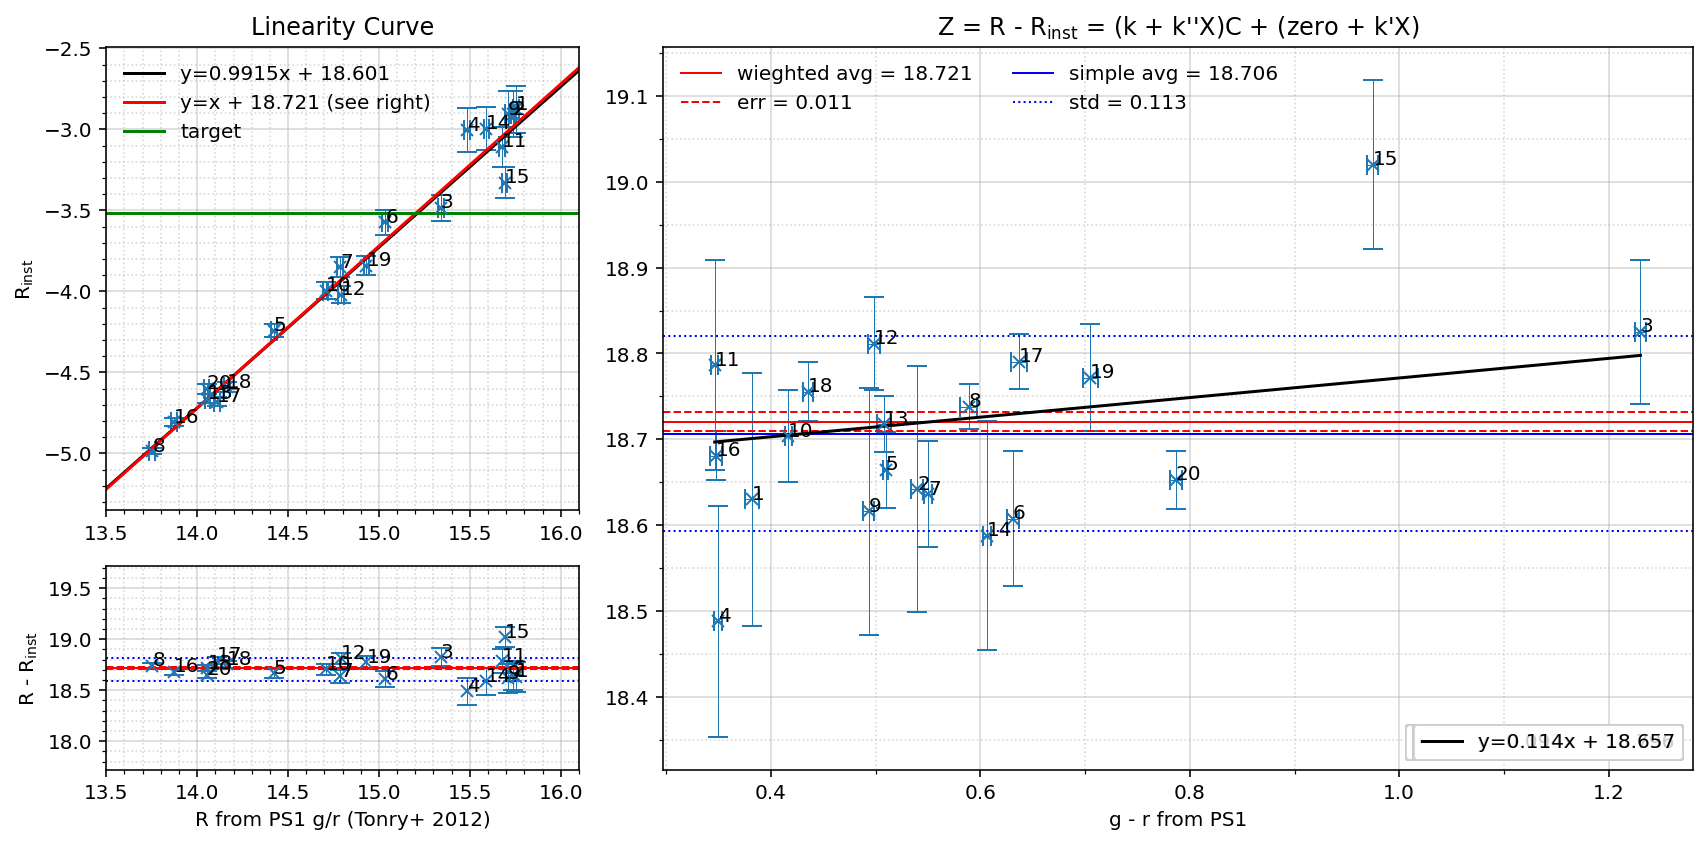

In [44]:
#problem 4

fwhm = 3                  # Check this from, e.g., ginga, a priori.
near = []
phot_targs = []
apkw = dict(fwhm=fwhm, f_ap=2, f_in=4, f_out=6)

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 3)
# NOTE: Z = R - R_inst = zp + 1st ext
ax_l = fig.add_subplot(gs[:2, 0])                # Linearity plot
ax_r = fig.add_subplot(gs[2, 0], sharex=ax_l)    # residual plot
ax_c = fig.add_subplot(gs[:, 1:])                # C(g-r) VS Z plot

for row in summary:
    ### Set paths for loading and saving
    fpath = Path(row['file'])
    regpath = fpath.parent/f"{fpath.stem}.reg"
    starspath = fpath.parent/f"{fpath.stem}_stars.csv"
    figpath = fpath.parent/f"{fpath.stem}.pdf"

    print(fpath, f'(RA, DEC) = ({row["RA"]:.5f}, {row["DEC"]:+.5f}) [deg]')
    
    ### load CCD and calcualte errors
    ccd = yfu.load_ccd(fpath)
    hdr = ccd.header
    err = yfu.make_errmap(ccd, gain_epadu=gain, rdnoise_electron=rdnoise)

    
    ### Query sidereal objects (PS1)

    # Position of the telescope FOV center (RA/DEC of the pixel at the center)
    try:
        cent_coord = yfu.center_radec(header=hdr, center_of_image=True)
    except ValueError: # some files do not have correct WCS... my bad (ysBach 2020-05-31 21:31:25)
        continue
    # FOV radius
    rad = yfu.fov_radius(header=hdr, unit=u.deg)

    # Initialize PanSTARRS1 class
    ps1 = ypu.PanSTARRS1(
        ra=cent_coord.ra.value, 
        dec=cent_coord.dec.value, 
        radius=rad,
        column_filters={"rmag":'10.0..16.0', "e_rmag":'<0.10'}
    )
    
    # Organize PanSTARRS1 query result.
    isnear = ypu.organize_ps1_and_isnear(
        ps1=ps1,
        header=hdr,
        bezel=50,
        group_crit_separation=6*fwhm,
        select_filter_kw=dict(filter_names=['g', 'r'], n_mins=5),
        drop_by_Kron=True,
        calc_JC=True  # This uses g-r color, so both g and r must not be removed.
    )
    stars = ps1.queried

    # Check if any object near to our target
    if isnear:
        near.append(fpath)

    ### Make DS9 region file
    mkreg(stars, row, 2.*fwhm_arcsec, regpath)
    
    ### Do photometry
    
    # Make apertures
    targ_xy = ypu.get_xy(hdr, row["RA"], row["DEC"])
    ap_stars, an_stars = ypu.circ_ap_an([stars["x"], stars["y"]], **apkw)
    ap_targ, an_targ = ypu.circ_ap_an(targ_xy, **apkw)

    # photometry for target
    phot_targ = ypu.apphot_annulus(
        ccd=ccd, 
        aperture=ap_targ, 
        annulus=an_targ, 
        error=err)

    # photometry for stars
    phot_stars = ypu.apphot_annulus(ccd=ccd, aperture=ap_stars, annulus=an_stars, error=err)
    phot_stars = hstack([phot_stars, stars]).to_pandas()
    phot_stars.to_csv(starspath, index=False)

    ### Find Z value
    # Plot curves & get zero-point fitting result
    res = plotting(ax_l, ax_r, ax_c, phot_stars, phot_targ)
    phot_targ["file"] = row["file"]
    phot_targ["nstar"] = len(phot_stars)
    for k, v in res.items():
        phot_targ[k] = v

    # Targetocentric time: the time when the light departed the target
    phot_targ["target_jd"] = (Time(row["datetime_jd"], format='jd') + row["lighttime"]*u.s).jd
    
    # Standardized magnitude
    phot_targ["mstd"] = phot_targ["mag"] + phot_targ["Zpt"]
    phot_targ["e_mstd"] = np.sqrt(phot_targ["merr"]**2 + phot_targ["e_Zpt"]**2)
    
    # Reduced magnitude (error is same as e_mstd)
    phot_targ["mred"] = phot_targ["mstd"] - 5*np.log10(row["r"]*row["delta"])

    # Include all minor details for debugging purpose:
    for c in row.columns:
        if c == "file":
            # This part is essential for Windows users, because
            # path separator is ``\\``, which is interpreted badly
            # in table column.... Otherwise it raises ``UnicodeDecodeError``. 
            # Holy moly Guaca-mole
            phot_targ[c] = r"{}".format(row[c])
        else:
            try:
                phot_targ[c] = row[c]
            except ValueError:
                pass


#     phot_targ["airmass"] = row["airmass"]

    plt.savefig(figpath)
    
    phot_targs.append(phot_targ)

In [38]:
#problem 5: I did
#problem 6: I did

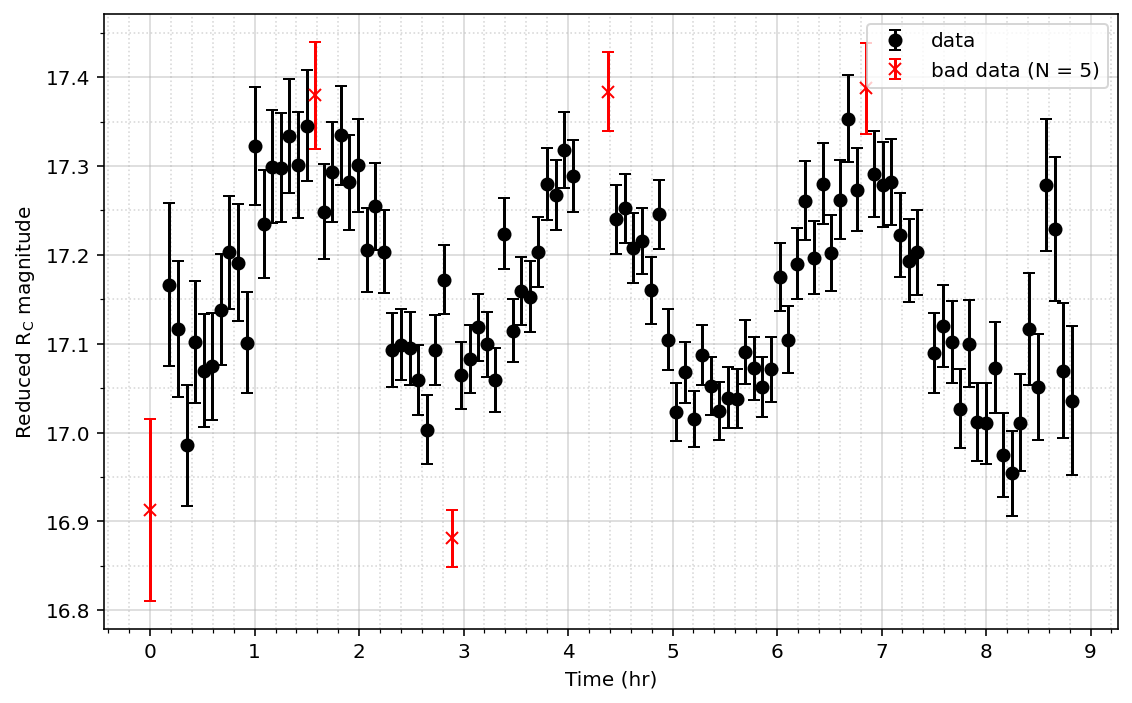

In [45]:
#Light curve
#problem 1
phot_targs_tab = vstack(phot_targs)

phot_targs_tab.write(TOPPATH/"20191012_2005UD_phot.csv")

baddata = sigma_clip(phot_targs_tab["mred"], sigma=2., maxiters=5).mask
baddata |= phot_targs_tab["e_mstd"] > 0.1

x = phot_targs_tab["target_jd"]
x = (x - x.min()) * 24  # to hours
y = phot_targs_tab["mred"]
yerr = phot_targs_tab["e_mstd"]

fig, axs = plt.subplots(1, 1, figsize=(8, 5), 
                        sharex=False, sharey=False, gridspec_kw=None)
axs.errorbar(x[~baddata], y[~baddata], yerr=yerr[~baddata], 
             ls='', capsize=3, marker='o', color='k',
             label="data")
axs.errorbar(x[baddata], y[baddata], yerr=yerr[baddata], 
             ls='', capsize=3, marker='x', color='r', 
             label=f"bad data (N = {np.count_nonzero(baddata)})")
axs.legend()
axs.set(xlabel="Time (hr)", ylabel=r"Reduced $\mathrm{R_C}$ magnitude")
yvu.linticker(axs, xmajlockws=1, xminlockws=0.2, ymajlockws=0.1, yminlockws=0.05)
plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)
plt.show()

#rotational period ~ 3hr

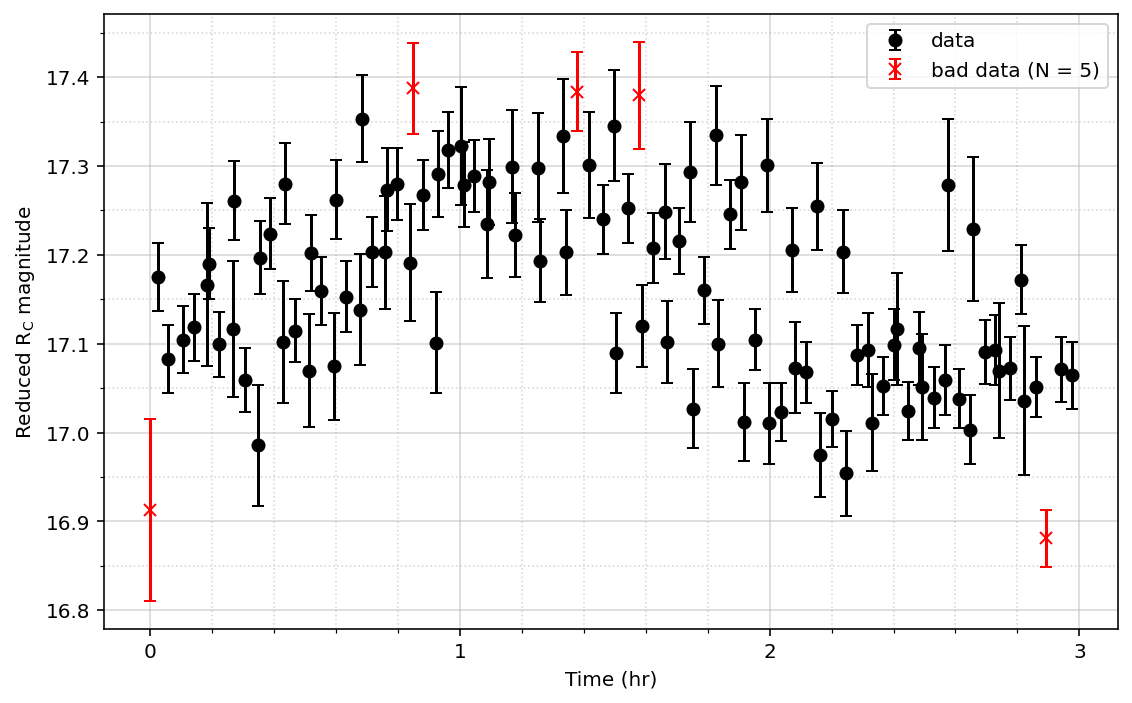

In [40]:
#problem 2
phot_targs_tab = vstack(phot_targs)

phot_targs_tab.write(TOPPATH/"20191012_2005UD_phot.csv")

baddata = sigma_clip(phot_targs_tab["mred"], sigma=2., maxiters=5).mask
baddata |= phot_targs_tab["e_mstd"] > 0.1

x = phot_targs_tab["target_jd"]
x = (x - x.min()) * 24  # to hours
y = phot_targs_tab["mred"]
yerr = phot_targs_tab["e_mstd"]
x = x%3

fig, axs = plt.subplots(1, 1, figsize=(8, 5), 
                        sharex=False, sharey=False, gridspec_kw=None)
axs.errorbar(x[~baddata], y[~baddata], yerr=yerr[~baddata], 
             ls='', capsize=3, marker='o', color='k',
             label="data")
axs.errorbar(x[baddata], y[baddata], yerr=yerr[baddata], 
             ls='', capsize=3, marker='x', color='r', 
             label=f"bad data (N = {np.count_nonzero(baddata)})")
axs.legend()
axs.set(xlabel="Time (hr)", ylabel=r"Reduced $\mathrm{R_C}$ magnitude")
yvu.linticker(axs, xmajlockws=1, xminlockws=0.2, ymajlockws=0.1, yminlockws=0.05)
plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)
plt.show()

In [41]:
#problem 3
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_lc(prot):
    x = phot_targs_tab['target_jd']
    x = (x - x.min()) * 24
    y = phot_targs_tab['mred']
    yerr = phot_targs_tab['e_mstd']
    x = x%prot
    
    fig, axs = plt.subplots(1,1,figsize = (8,5), sharex = False, sharey = False, gridspec_kw = None)
    
    ax = axs
    
    ax.errorbar(x[~baddata], y[~baddata], yerr = yerr[~baddata], ls = '', capsize = 3, marker = 'o', color = 'k', label = 'data')
    ax.errorbar(x[baddata], y[baddata], yerr = yerr[baddata], ls = '', capsize = 3, marker = 'x', color = 'r', label = f"bad data (N = {np.count_nonzero(baddata)})")
    
    ax.legend()
    ax.set(xlabel = "Time (hr)", ylabel = r"Reduced $\mathrm{R_C}$ magnitude")
    yvu.linticker(ax, xmajlockws = 1, xminlockws = 0.2, ymajlockws = 0.1, yminlockws = 0.05)
    
    plt.tight_layout()
    fig.align_ylabels(ax)
    fig.align_xlabels(ax)
    plt.show()
    
s_p = widgets.SelectionSlider(description = "Rotational Period[hr]", options = np.arange(5, 5.5, 0.01))

interact(plot_lc, prot = s_p)

interactive(children=(SelectionSlider(description='Rotational Period[hr]', options=(5.0, 5.01, 5.02, 5.0299999…

<function __main__.plot_lc(prot)>

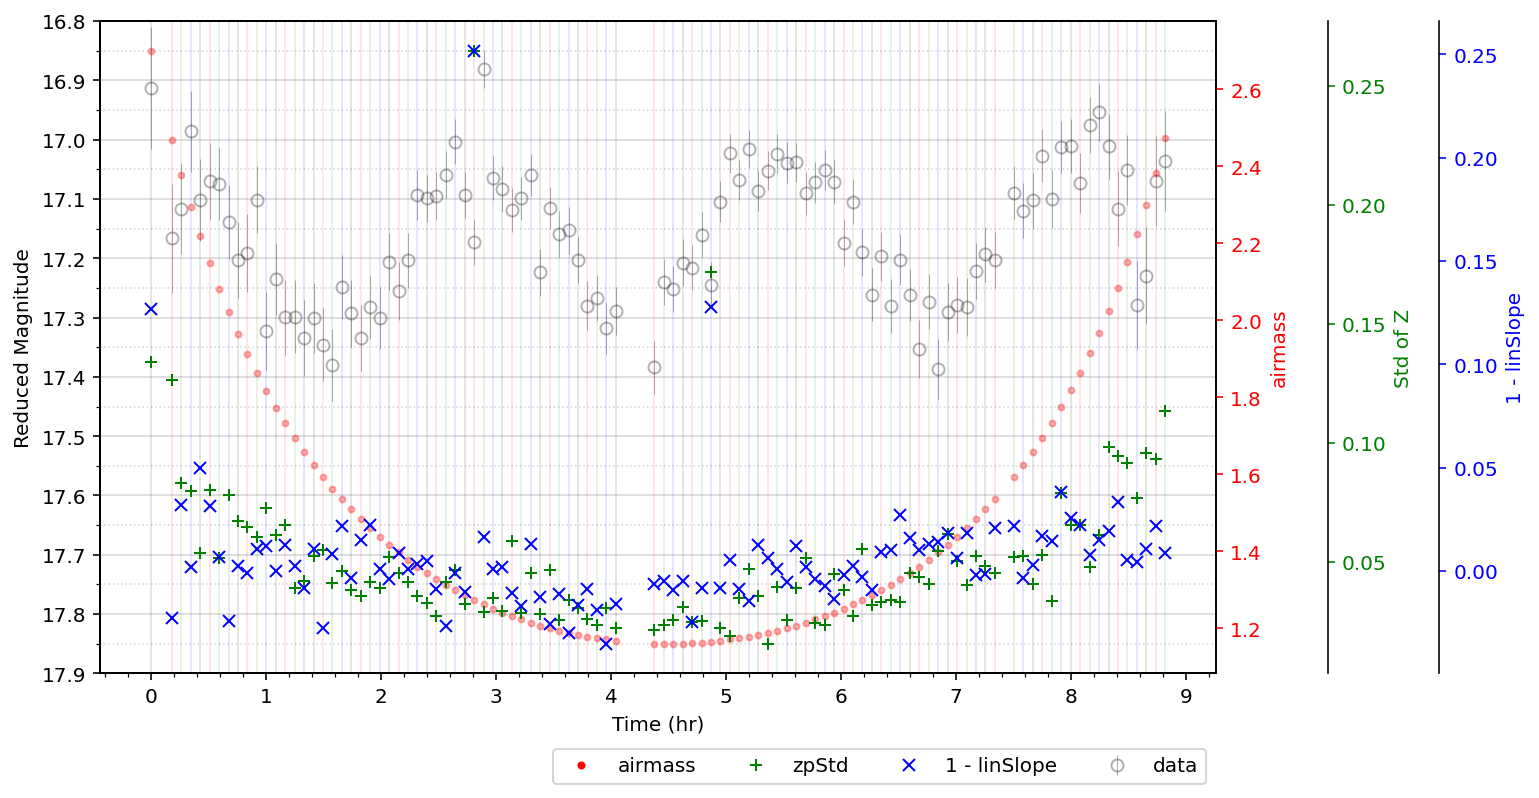

In [42]:
#problem 4
errbfmt = dict(capsize=0, elinewidth=0.5, ls='')
dummy = ([np.nan], [np.nan])
cols = ['k', 'r', 'g', 'b']
x = phot_targs_tab["target_jd"]
x = (x - x.min()) * 24  # to hours
y = phot_targs_tab["mred"]
yerr = phot_targs_tab["e_mstd"]
airmass = phot_targs_tab['airmass']
dlinSlope = 1 - phot_targs_tab["linSlope"]
Zstd = phot_targs_tab["Zstd"]

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
ax = axs
ax.errorbar(x, y, yerr=yerr, **errbfmt,
            label="data", marker='o', color='k', mfc='none',
            alpha=0.3)
ax.plot(*dummy, 'r.', label="airmass")
ax.plot(*dummy, 'g+', label="zpStd")
ax.plot(*dummy, 'bx', label="1 - linSlope")

for i, xpos in enumerate(x):
    ax.axvline(xpos, lw=0.1, color=cols[i%len(cols)])

ax_a = ax.twinx()
ax_a.plot(x, airmass, 'r.', alpha=0.3)
ax_a.set_ylabel("airmass", color='r')
ax_a.tick_params('y', colors='r')

ax_s = ax.twinx()
ax_s.spines["right"].set_position(("axes", 1.1))
ax_s.plot(x, Zstd, 'g+')
ax_s.set_ylabel("Std of Z", color='g')
ax_s.tick_params('y', colors='g')

ax_l = ax.twinx()
ax_l.spines["right"].set_position(("axes", 1.2))
ax_l.plot(x, dlinSlope, 'bx')
ax_l.set_ylabel("1 - linSlope", color='b')
ax_l.tick_params('y', colors='b')


ax.set(ylim=(17.9, 16.8),
       xlabel="Time (hr)", 
       ylabel="Reduced Magnitude")
ax.legend(loc=1, ncol=4, bbox_to_anchor=(1, -0.1))
    
yvu.linticker(ax, xmajlockws=1, xminlockws=0.2, ymajlockws=0.1, yminlockws=0.05, 
              xmajgrids=False, xmingrids=False)

In [ ]:
#Some science
#problem 1
